<a href="https://colab.research.google.com/github/mohit2494/python3-bootcamp/blob/master/Copy_of_TestRank_Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx

In [0]:
def get_sentences(article_text):
    # file = open(file_name, "r")
    # filedata = file.readlines()
    article = article_text.split(". ")
    sentences = []

    for sentence in article:
        # print(sentence)
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop() 
    
    return sentences

In [0]:
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [0]:
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix

In [0]:
def generate_summary(article_text, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text anc split it
    sentences =  get_sentences(article_text)

    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)

    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    # print("Indexes of top ranked_sentence order are ", ranked_sentence)    

    for i in range(min(len(ranked_sentence),top_n)):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    # Step 5 - Offcourse, output the summarize texr
    return ". ".join(summarize_text)


In [197]:
data=pd.read_csv("data.csv") #,nrows=158018
print("Total number of rows read in : " ,len(data))
data.info()

Total number of rows read in :  2224
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2224 entries, 0 to 2223
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     2224 non-null   object
 1   Summary  2224 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [198]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
print("Total number of rows after dropping duplicates on column 'Text' : ", len(data))
data.dropna(axis=0,inplace=True)#dropping na
print("Total number of rows after dropping N/A values on column 'Text' : ", len(data))

Total number of rows after dropping duplicates on column 'Text' :  2091
Total number of rows after dropping N/A values on column 'Text' :  2091


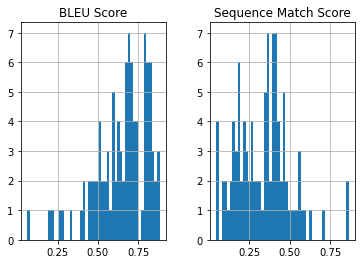

In [199]:
import matplotlib.pyplot as plt
from difflib import SequenceMatcher
data=data.sample(n=100)
ratios=[]
bleuList=[]
for index,row in data.iterrows():
  
  b = row['Summary']
  a = generate_summary(row['Text'])
  ratio = SequenceMatcher(None, a, b).ratio()
  ratios.append(ratio)
  hypothesis = list(a)
  reference = list(b)
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
  bleuList.append(BLEUscore)

length_df = pd.DataFrame({'Sequence Match Score':ratios,'BLEU Score':bleuList})
length_df.hist(bins=50)
plt.show()